In [ ]:
import os
import pandas as pd
from pathlib import Path
import miditoolkit
from tqdm import tqdm
import pretty_midi
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def extract_midi_metadata(midi_path):
    try:
        midi = miditoolkit.midi.parser.MidiFile(midi_path)


        return {
            "file": str(midi_path),
            "filename": midi_path.name,
            "num_tracks": len(midi.instruments),
            "total_notes": sum(len(track.notes) for track in midi.instruments),
            "programs": set([inst.program for inst in midi.instruments if not inst.is_drum]),
            "tempos": midi.tempo_changes[0].tempo if midi.tempo_changes else None,
            "time_signatures": '/'.join([str(midi.time_signature_changes[0].numerator), str(midi.time_signature_changes[0].denominator)]) if midi.time_signature_changes else None,  
            "key_signatures": midi.key_signature_changes[0].key_name if midi.key_signature_changes else None,
            "duration_secs": midi.max_tick / midi.ticks_per_beat
        }
    except Exception as e:
        return {
            "file": str(midi_path),
            "filename": midi_path.name,
            "error": str(e)
        }

In [23]:
# Full MIDI tracks
midi_dir = Path("../../data")
midi_files = sorted(midi_dir.rglob("*.mid"))
data_path = Path("midi_metadata.csv")
if not os.path.exists(data_path):

    # Extract all metadata
    metadata = [extract_midi_metadata(path) for path in tqdm(midi_files, desc="Extracting MIDI metadata")]

    # Create DataFrame
    df = pd.DataFrame(metadata)

    df.to_csv(data_path, index=False)
else:
    df = pd.read_csv(data_path)
df


Extracting MIDI metadata: 100%|██████████| 426/426 [00:24<00:00, 17.66it/s]


,file,filename,num_tracks,total_notes,programs,tempos,time_signatures,key_signatures,duration_secs
0,..\..\data\acsrnade.mid,acsrnade.mid,2,1652,{0},150.000000,4/4,C,406.008333
1,..\..\data\adingysd.mid,adingysd.mid,2,2353,{0},80.000000,2/4,Bb,308.008333
2,..\..\data\adlyn.mid,adlyn.mid,2,4650,{0},89.720029,2/4,D,2678.008333
3,..\..\data\afrcnpas.mid,afrcnpas.mid,2,2041,{0},83.999966,2/4,G,235.008333
4,..\..\data\agitaton.mid,agitaton.mid,2,2971,{0},91.919932,2/4,Bb,307.941667
...,...,...,...,...,...,...,...,...,...
421,..\..\data\wwillowr.mid,wwillowr.mid,2,1703,{0},80.000000,2/4,Eb,235.008333
422,..\..\data\xlrag.mid,xlrag.mid,2,2282,{0},94.809946,4/8,Db,275.008333
423,..\..\data\yellwdog.mid,yellwdog.mid,2,2124,{0},151.999939,4/4,D,384.508333
424,..\..\data\ywesmile.mid,ywesmile.mid,2,1742,{0},86.000052,2/4,F,238.008333


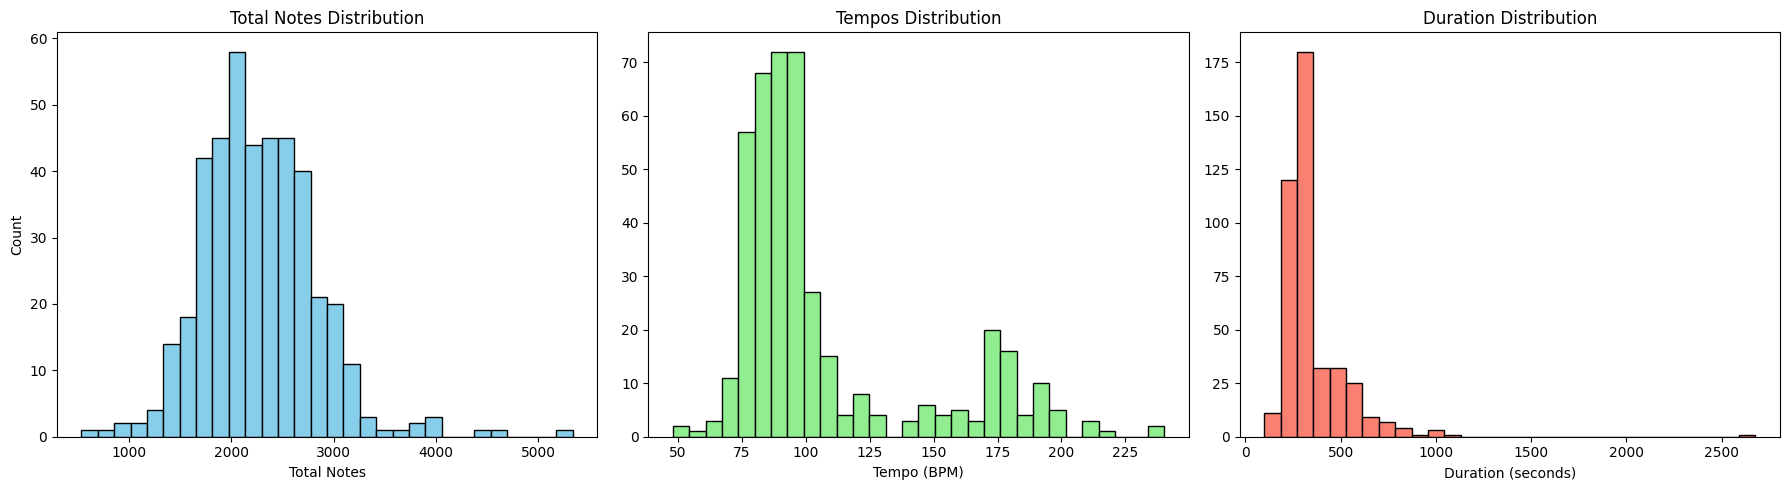

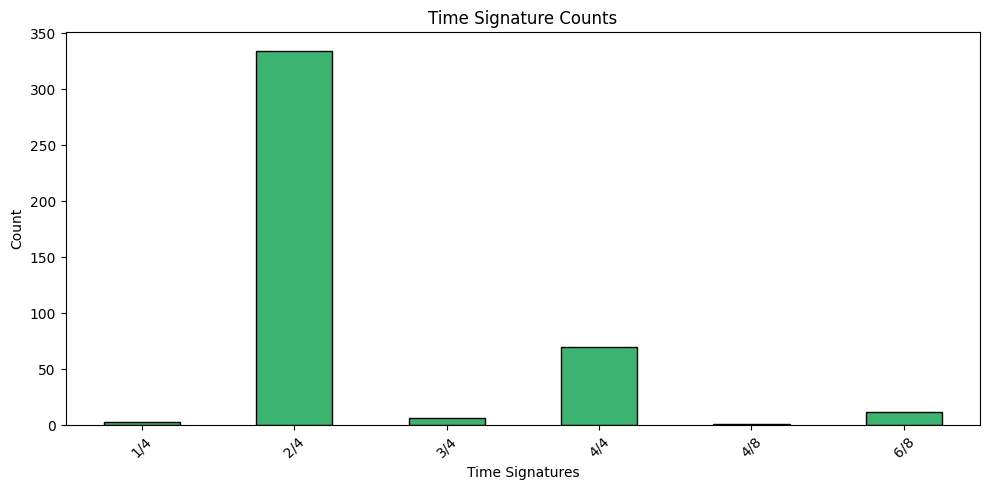

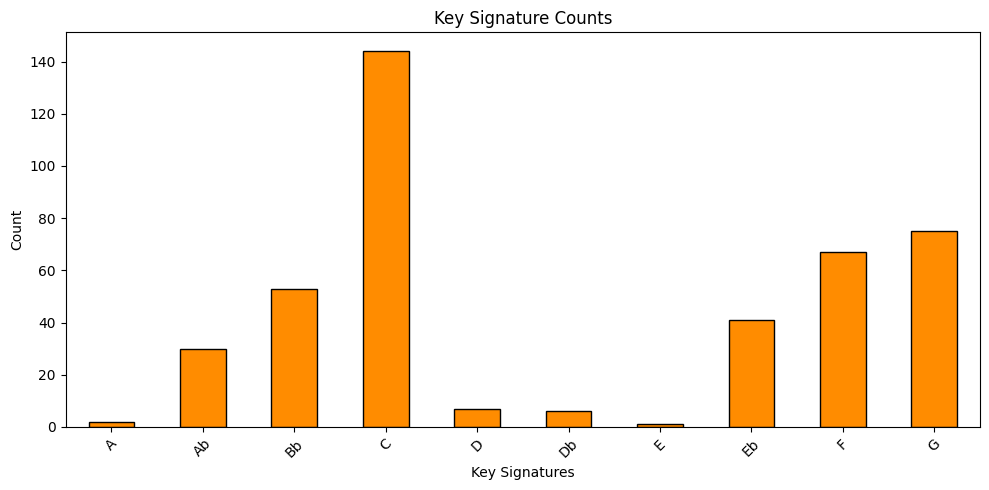

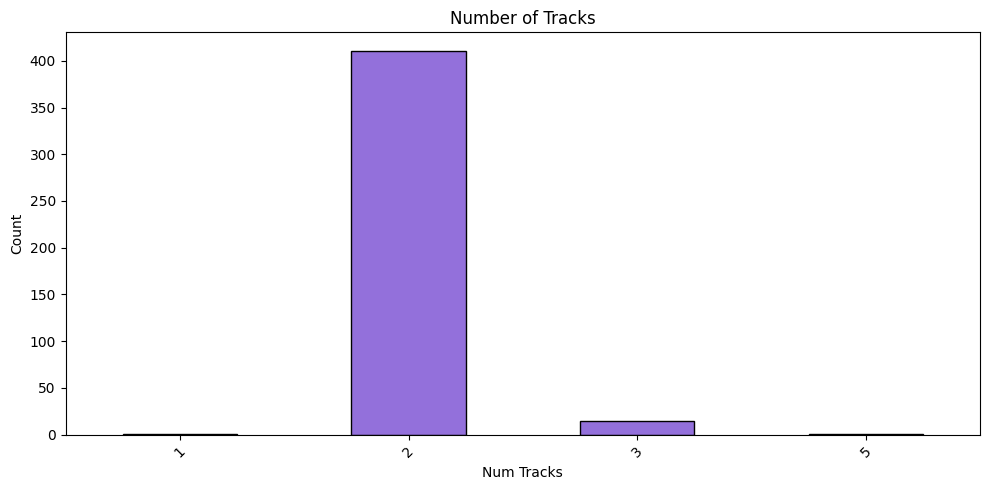

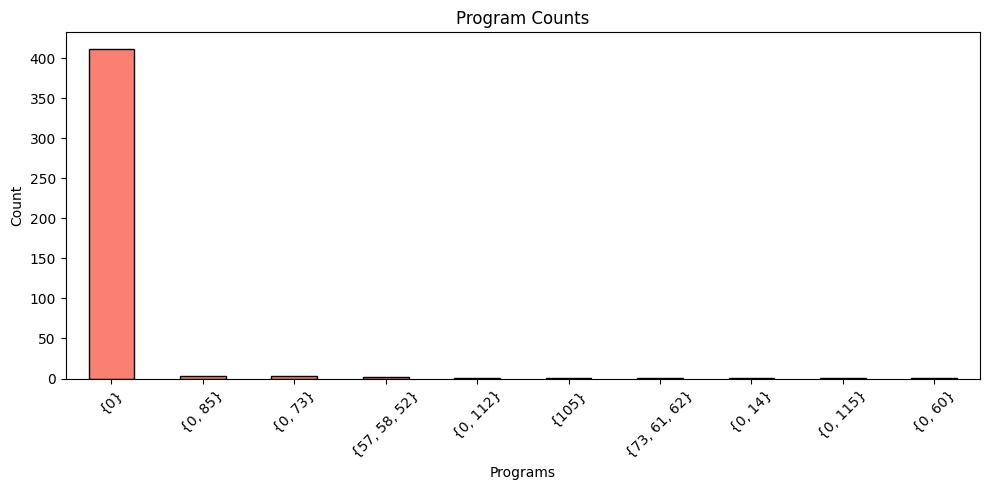

In [31]:
import matplotlib.pyplot as plt

def plot_histograms(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].hist(df['total_notes'], bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title('Total Notes Distribution')
    axes[0].set_xlabel('Total Notes')
    axes[0].set_ylabel('Count')

    axes[1].hist(df['tempos'], bins=30, color='lightgreen', edgecolor='black')
    axes[1].set_title('Tempos Distribution')
    axes[1].set_xlabel('Tempo (BPM)')
    
    axes[2].hist(df['duration_secs'], bins=30, color='salmon', edgecolor='black')
    axes[2].set_title('Duration Distribution')
    axes[2].set_xlabel('Duration (seconds)')
    
    plt.tight_layout()
    plt.show()

def plot_bar_counts(df, column, title, color='mediumpurple'):
    counts = df[column].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar', color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage with your dataframe `df`
plot_histograms(df)
plot_bar_counts(df, 'time_signatures', 'Time Signature Counts', color='mediumseagreen')
plot_bar_counts(df, 'key_signatures', 'Key Signature Counts', color='darkorange')
plot_bar_counts(df, 'num_tracks', 'Number of Tracks', color='mediumpurple')
plot_bar_counts(df, 'programs', 'Program Counts', color='salmon')



In [28]:


def extract_note_chord_freq(midi_path):
    """Extract note and chord frequency info from a MIDI file."""
    midi = miditoolkit.MidiFile(str(midi_path))

    notes = []
    chords = []

    # Collect notes and chords from all instruments (usually one instrument per file here)
    for inst in midi.instruments:
        notes += [note.pitch for note in inst.notes]
        chords += [tuple(sorted([p.pitch for p in chord.notes])) for chord in getattr(inst, "chords", [])]

    note_freq = dict(Counter(notes))
    chord_freq = dict(Counter(chords))

    return note_freq, chord_freq


def extract_additional_features(midi_path):
    """Extract additional MIDI features."""
    midi = miditoolkit.MidiFile(str(midi_path))
    pm = pretty_midi.PrettyMIDI(str(midi_path))

    notes = [note for inst in midi.instruments for note in inst.notes]
    if not notes:
        return {}

    durations = [note.end - note.start for note in notes]
    velocities = [note.velocity for note in notes]
    pitches = [note.pitch for note in notes]

    pitch_classes = [p % 12 for p in pitches]
    pitch_class_counts = dict(sorted(Counter(pitch_classes).items()))

    duration_secs = pm.get_end_time()
    note_density = len(notes) / duration_secs if duration_secs > 0 else 0

    pitch_range = max(pitches) - min(pitches)
    avg_velocity = sum(velocities) / len(velocities)
    avg_duration = sum(durations) / len(durations)

    if midi.time_signature_changes:
        ts = midi.time_signature_changes[0]
        beats_per_bar = ts.numerator
        ticks_per_beat = midi.ticks_per_beat
        total_bars = midi.max_tick / (ticks_per_beat * beats_per_bar)
    else:
        total_bars = None

    data = {
        "pitch_class_histogram": pitch_class_counts,
        "note_density": note_density,
        "pitch_range": pitch_range,
        "avg_velocity": avg_velocity,
        "avg_note_duration": avg_duration,
        "total_bars": total_bars,
    }
    return data


def process_hand_midis(midi_dir: Path):
    """Process all MIDI files in a directory, extracting features into a DataFrame."""
    rows = []

    for midi_path in midi_dir.glob("*.mid"):
        note_freq, chord_freq = extract_note_chord_freq(midi_path)
        features = extract_additional_features(midi_path)

        row = {
            "filename": midi_path.name,
            "note_freq": note_freq,
            "chord_freq": chord_freq,
            **features,
        }
        rows.append(row)

    return pd.DataFrame(rows)



right_hand_dir = Path("data_right_hand")
left_hand_dir = Path("data_left_hand")

df_right = process_hand_midis(right_hand_dir)
df_left = process_hand_midis(left_hand_dir)


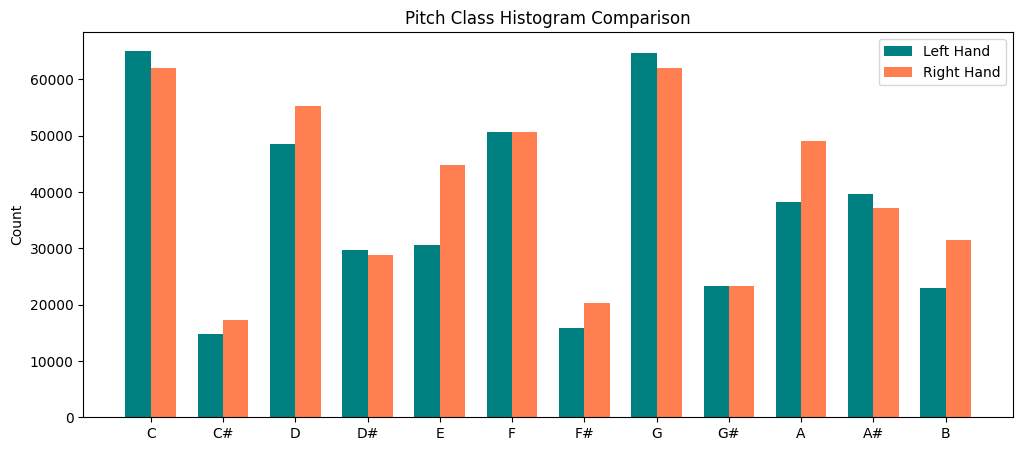

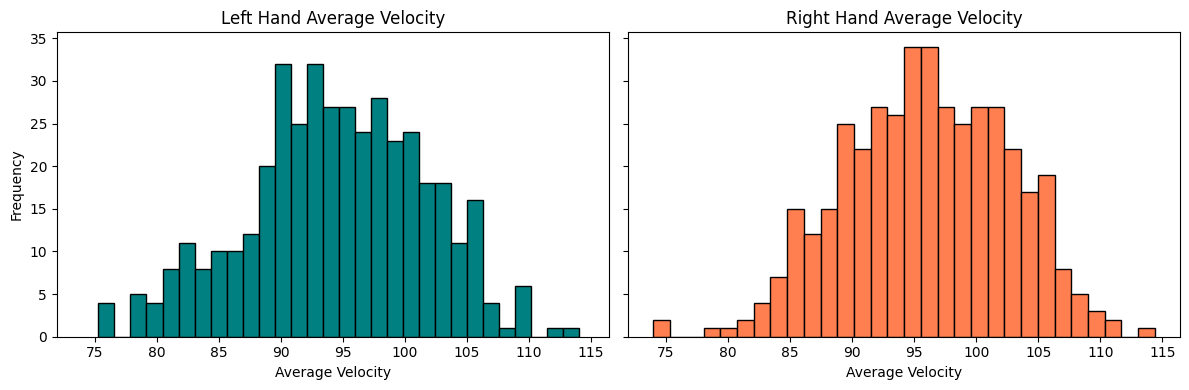

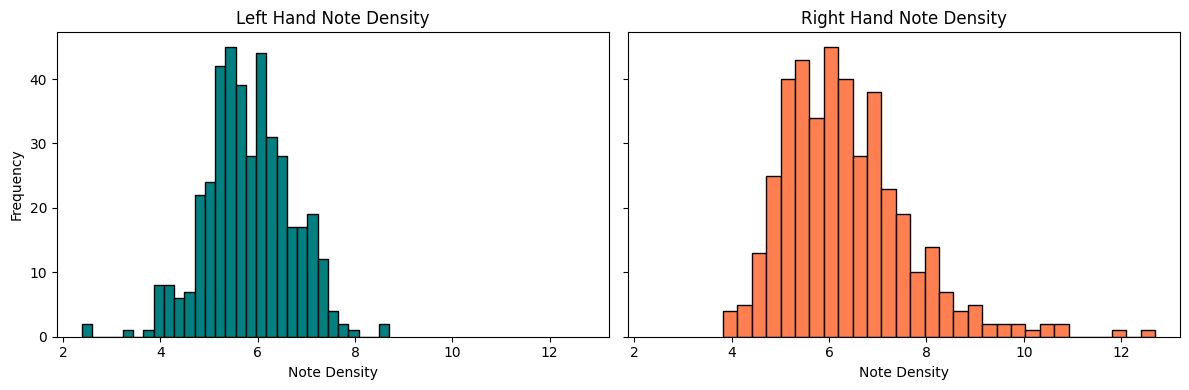

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def aggregate_pitch_histogram(df):
    """Aggregate pitch class histograms over all rows in the DataFrame."""
    agg_hist = Counter()
    for hist in df['pitch_class_histogram']:
        agg_hist.update(hist)
    # Convert to sorted list by pitch class 0..11
    return [agg_hist.get(i, 0) for i in range(12)]

def plot_pitch_histograms_side_by_side(df_left, df_right):
    left_hist = aggregate_pitch_histogram(df_left)
    right_hist = aggregate_pitch_histogram(df_right)

    classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)
    ax.bar(x - width/2, left_hist, width, label='Left Hand', color='teal')
    ax.bar(x + width/2, right_hist, width, label='Right Hand', color='coral')

    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylabel('Count')
    ax.set_title('Pitch Class Histogram Comparison')
    ax.legend()
    plt.show()

def plot_feature_histograms_side_by_side(df_left, df_right, feature, bins=30, feature_name=None):
    feature_name = feature_name or feature

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)

    # Left hand plot
    axes[0].hist(df_left[feature].dropna(), bins=bins, color='teal', edgecolor='black')
    axes[0].set_title(f"Left Hand {feature_name}")
    axes[0].set_xlabel(feature_name)
    axes[0].set_ylabel("Frequency")

    # Right hand plot
    axes[1].hist(df_right[feature].dropna(), bins=bins, color='coral', edgecolor='black')
    axes[1].set_title(f"Right Hand {feature_name}")
    axes[1].set_xlabel(feature_name)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_pitch_histograms_side_by_side(df_left, df_right)

plot_feature_histograms_side_by_side(df_left, df_right, 'avg_velocity', feature_name="Average Velocity")
plot_feature_histograms_side_by_side(df_left, df_right, 'note_density', feature_name="Note Density")
